In [252]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define model architecture
class DCGMNet(tf.keras.Model):
    """ Set basic architecture of the model."""

    def __init__(self, X_low, X_high,
                 input_dim, output_dim,
                 n_layers_FFNN, layer_width,
                 activation_FFNN,
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)
        
        self.X_low = X_low
        self.X_high = X_high
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.n_layers_FFNN = n_layers_FFNN
        self.layer_width = layer_width
        
        self.activation_FFNN = activation_FFNN
        # print(activation_FFNN)
        
        # Define NN architecture
        self.initial_scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - X_low)/(X_high - X_low) - 1.0)
        self.hidden = [tf.keras.layers.Dense(layer_width,
                                             activation=tf.keras.activations.get(
                                                 activation_FFNN),
                                             kernel_initializer=kernel_initializer)
                       for _ in range(self.n_layers_FFNN)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = self.initial_scale(X)
        for i in range(self.n_layers_FFNN):
            Z = self.hidden[i](Z) +Z
        return self.out(Z)




In [253]:
X_low = np.array([-0.02])  # wealth lower bound
X_high = np.array([2])          # wealth upper bound


# neural network parameters
num_layers_FFNN = 4
num_layers_RNN = 0
nodes_per_layer = 50
starting_learning_rate = 0.001
shrinkstep = 20000
shrinkcoef = 0.95
activation_FFNN = 'tanh'
# Training parameters
sampling_stages  = 20000   # number of times to resample new time-space domain points
steps_per_sample = 10    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 256
nSim_boundary = 1

dim_input = 1
dim_output = 2
 
model = DCGMNet(X_low, X_high,  
                 dim_input, dim_output, 
                 num_layers_FFNN, nodes_per_layer,
                 activation_FFNN)





In [254]:
# Aiyagari problem parameters
gamma = 2
r = 0.03
rho = 0.05
Var = 0.07
Corr = 0.9
the = -np.log(Corr)
sig2 = 2*the*Var

z1 = .1
z2 = .2
z = np.array([z1, z2])
la1 = 0.02
la2 = 0.03
la = np.array([la1, la2])

eps = tf.constant(1e-10, dtype=tf.float32)


def u(c):
    return c**(1-gamma)/(1-gamma)


def u_deriv(c):
    return c**(-gamma)


def u_deriv_inv(c):
    return c**(-1/gamma)


In [255]:

def sampler(nSim_interior, nSim_boundary):
    ''' Sample space points from the function's domain
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at boundary to sample 
    ''' 
    
    # Sampler #1: domain interior    

    X_interior = tf.random.uniform(
        shape=[nSim_interior, 1], minval=X_low, maxval=X_high, dtype=tf.float32)


    a_alower = X_low[0] * tf.ones(shape = (nSim_boundary, 1), dtype=tf.float32)
    X_alower = a_alower

    return X_interior, X_alower


def loss_differentialoperator(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_a = tf.math.maximum(eps*tf.ones_like(V), V_a)


    c = u_deriv_inv(V_a)
    u_c = u(c) 
    
    diff_V_z1 = -rho * V[:, 0] + u_c[:, 0] + V_a[:, 0] * (z[0]+r*a[:, 0]-c[:, 0]) + la[0] * (V[:, 1] - V[:, 0])
    diff_V_z2 = -rho * V[:, 1] + u_c[:, 1] + V_a[:,1] * (z[1]+r*a[:,0]-c[:,1]) + la[1]* (V[:,0] - V[:,1])

    diff_V = tf.concat([diff_V_z1,diff_V_z2], axis=0)
        
    L = tf.reduce_mean(tf.square(diff_V))
    return diff_V, L

def loss_differentialoperator_alower(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_a = tf.math.maximum( tf.zeros_like(V), V_a)
    V_a_new = tf.math.maximum(u_deriv(z+ r* a), V_a)

    c_new = u_deriv_inv(V_a_new)
    u_c_new = u(c_new) 
    

    diff_V_z1 = -rho * V[:,0] + u_c_new[:,0] + V_a[:,0]*(z[0]+r*a[:,0]-c_new[:,0]) + la[0]* (V[:,1] - V[:,0])
    diff_V_z2 = -rho * V[:,1] + u_c_new[:,1] + V_a[:,1]*(z[1]+r*a[:,0]-c_new[:,1]) + la[1]* (V[:,0] - V[:,1])

    diff_V = tf.concat([diff_V_z1,diff_V_z2], axis=0)
        

    L = tf.reduce_mean(tf.square(diff_V))
    return diff_V, L

def loss_concave(model, X):
    a = X[:,0:1]

    V = model(tf.stack([a[:,0]], axis=1))
    V_a = tf.concat([tf.gradients(V[:,0], a)[0],tf.gradients(V[:,1], a)[0]],axis=1)
    V_aa = tf.concat([tf.gradients(V_a[:,0], a)[0],tf.gradients(V_a[:,1], a)[0]],axis=1)
    concave_V = tf.maximum(V_aa, tf.zeros_like(V))

    L = tf.reduce_mean( tf.square(concave_V ) )
    return L


def compute_loss(model, X_interior, X_alower):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        X_interior, X_alower:      Points

    ''' 

    Loss_V_interior, L1 = loss_differentialoperator(model, X_interior)

    Loss_V_alower, L2 = loss_differentialoperator_alower(model, X_alower)
    
    L3 =  loss_concave(model, X_interior)

    L4 = tf.cast(0,tf.float32)

    L = L1 + L2 + L3 + L4
    
    return L
    
    
def get_grad(model, X_interior, X_alower):
    
    with tf.GradientTape(persistent=True) as tape:

        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_interior, X_alower)

    grad = tape.gradient(loss, model.trainable_variables)
    del tape
    
    return loss, grad


In [256]:
optimizer = tf.keras.optimizers.Adam(learning_rate=starting_learning_rate)




@tf.function
def train_step(X_interior, X_alower):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_interior, X_alower)

    # Perform gradient descent step
    optimizer.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss


hist = []

for i in range(sampling_stages):

    # sample uniformly from the required regions

    X_interior, X_alower = sampler(nSim_interior, nSim_boundary)

    for _ in range(steps_per_sample):
        loss = train_step(X_interior, X_alower)
    
    hist.append(loss.numpy())
    
    if i%100==0:
        tf.print(i,loss)
    

0 64.0141678
100 2.33646774
200 0.130246535
300 0.0500449054
400 0.00636165589
500 0.00178621255
600 0.00067072938
700 0.000681244128
800 0.000532300503
900 0.000165845166
1000 6.82185637e-05
1100 5.30089e-05
1200 2.30861206e-05
1300 5.75161948e-06
1400 2.31418335e-06
1500 2.79506366e-06
1600 3.4906052e-06
1700 2.36398432e-06
1800 2.84827956e-06
1900 9.02853208e-06
2000 1.03475645e-06
2100 4.44186844e-06
2200 2.75424281e-06
2300 2.25666372e-06
2400 2.3031042e-07
2500 6.39521e-07
2600 1.35715982e-06
2700 1.6771005e-06
2800 3.47106067e-07
2900 9.73563274e-08
3000 2.58993805e-06
3100 7.28914529e-07
3200 1.20122941e-05
3300 1.11917348e-06
3400 1.15165079e-07
3500 5.11506812e-07
3600 7.62430273e-06
3700 8.91398486e-06
3800 1.68703536e-07
3900 2.59711805e-06
4000 1.05906383e-06
4100 5.17174499e-07
4200 7.97575e-07
4300 1.27309067e-06
4400 7.21477477e-07
4500 8.82548875e-07
4600 8.60596629e-07
4700 5.44447175e-07
4800 4.133326e-06
4900 9.2032721e-08
5000 6.83193434e-07
5100 1.25396991e-06
520

KeyboardInterrupt: 

Text(0.5, 1.0, 'Saving')

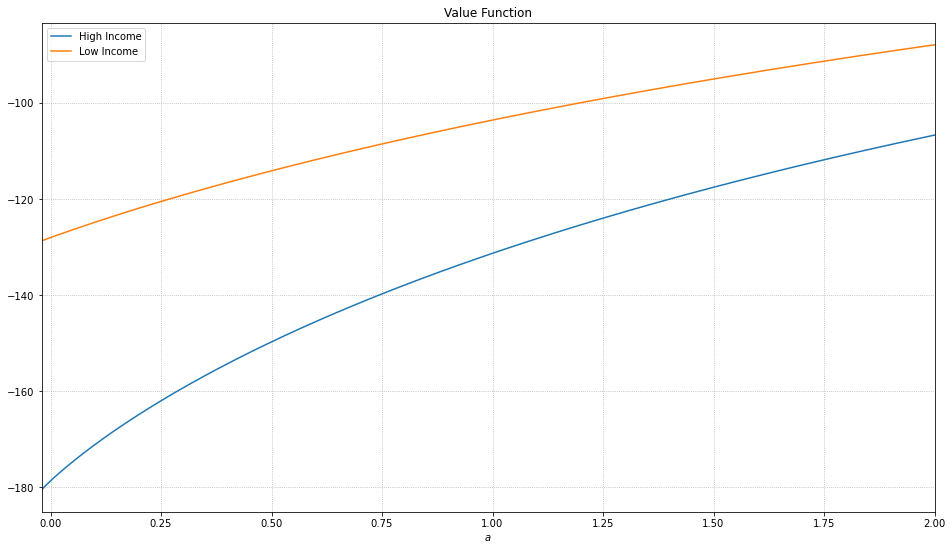

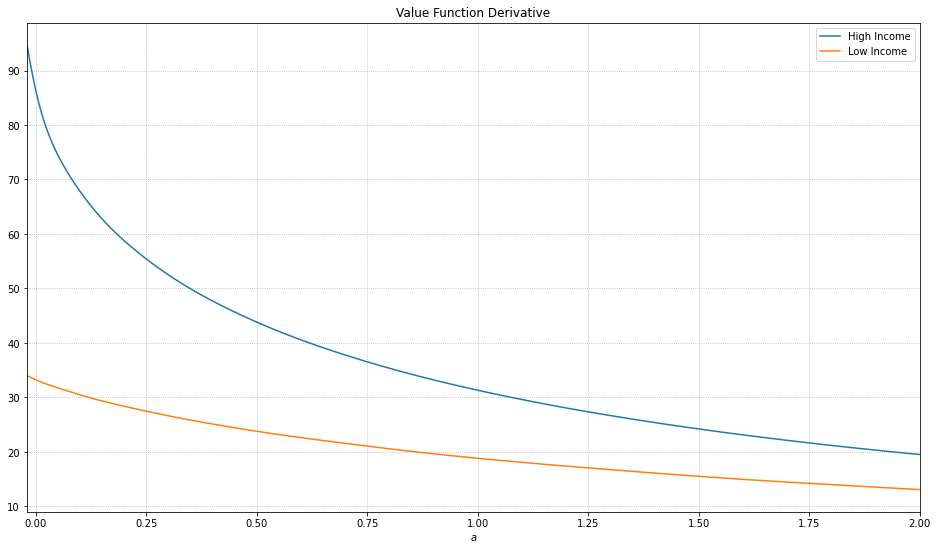

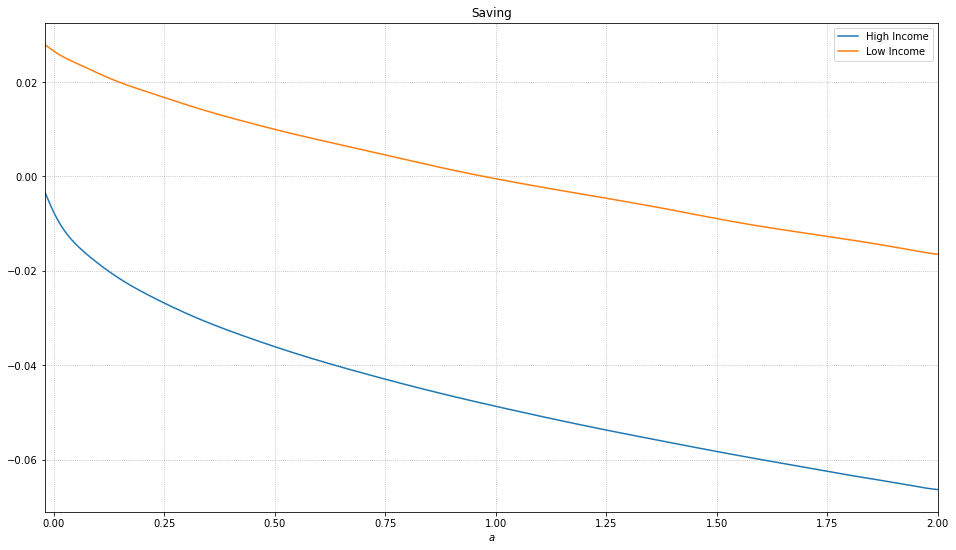

In [257]:



aspace = np.linspace(-0.02, 2, 500)
# A = np.meshgrid(aspace)
A = aspace
X_interior = np.vstack([A.flatten()]).T

X_alower = np.vstack([A[A==-0.02].flatten()]).T


with tf.GradientTape(persistent=True) as tape:
    a = tf.cast(X_interior, dtype=tf.float32)[:,0:1]
    tape.watch(a)
    V = model(tf.stack([a[:, 0]], axis=1))
    Va_1 = tape.gradient(V[:,0], a)
    Va_2 = tape.gradient(V[:, 1], a)
    Va = tf.concat([Va_1,Va_2],axis=1)

fitted_V = V.numpy().reshape(500, 2)
fitted_Va = Va.numpy().reshape(500,2)
fitted_saving = z+r*X_interior - u_deriv_inv(fitted_Va)

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_V[:, 0], label="High Income")
plt.plot(X_interior[:, 0], fitted_V[:, 1], label="Low Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low, X_high)
plt.title("Value Function")

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_Va[:, 0], label="High Income")
plt.plot(X_interior[:, 0], fitted_Va[:, 1], label="Low Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low, X_high)
plt.title("Value Function Derivative")

fig = plt.figure(figsize=(16, 9))
plt.plot(X_interior[:, 0], fitted_saving[:, 0], label="High Income")
plt.plot(X_interior[:, 0], fitted_saving[:, 1], label="Low Income")
plt.xlabel('$a$')
plt.legend()
plt.grid(linestyle=":")
plt.xlim(X_low,X_high)
plt.title("Saving")
